In [2]:
###--- import packages ---###

import numpy as np
import matplotlib.pyplot as plt
from PDE_FIND import *
import pandas as pd
import pickle
import matplotlib 
font = {'family': 'Arial'}
matplotlib.rc('font', **font)
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import scipy.signal # for savitzky-golay filer

### Import Data

In [26]:
###--- import data---###

T = [35,45,55,65,75,85]
DecData = pickle.load(open("data/ExperimentalData-LowVar",'rb'))
red = DecData['red']
time = DecData['time']

# converting all the colour vectors to same length - all samples
redl = []
for i in range(len(red)):
    redl_i = []
    for j in range(len(red[T[i]])):
        redl_i.append(np.concatenate((red[T[i]][j], np.ones(len(time)-len(red[T[i]][j]))*red[T[i]][j][-1])))
    redl.append(np.array(redl_i))
redl = np.array(redl)

# averaging over all samples for each temperature condition
rm = {}
for i in range(len(DecData['red'])):
    rm[T[i]] = np.mean(DecData['red'][T[i]],axis=0)

    
# converting red colour vectors to same length - average
rml = []
for i in range(len(rm)):
    rml.append(np.concatenate((rm[T[i]], np.ones(len(DecData['time'])-len(rm[T[i]]))*rm[T[i]][-1])))
rml = np.array(rml)


### Parameter Definitions

In [14]:
###--- PDE-FIND parameters ---###
dt = time[1] - time[0] 
dx = T[2] - T[1] 

P0=5 # max order of polynomial
D0=0 # only applicable for space derivative (not applicable in our case)
tol = 1 # threshold for STRidge
lam = 10**-5 # weight for regularization
method = 'FDConv' # method for numerical differentiation - Finite difference with smoothing

###--- odeint parameters ---###
atol0 = 10e-7
rtol0 = 10-10

### Function Definitions

In [5]:
# function to add Avrami terms of order n
def add_avrami(time, U, order, N):
    # initializations
    Rr = np.zeros((np.reshape(np.tile(np.power(time,order), (N, 2)),(len(time)*N,2), order = 'F')).shape)
    rhs_des = []
    
    # add t^n
    Rr[:,0] = np.reshape(np.tile(np.power(time,order), (N, 1)),(len(time)*N,), order = 'F')

    # add U*t^n
    Uu = np.reshape(np.tile(U, (N, 1)),(len(time)*N,), order = 'F')
    Rr[:,1] = np.reshape(np.multiply(Uu,Rr[:,0]),(-1,))
    
    # rhs descriptions
    rhs_des = ['t^'+str(order), 'U*t^'+str(order)]
    
    # 
    return Rr, rhs_des

### Library Preparation

In [8]:
###--- Our Data ---###
pde_data = np.vstack(redl[:]) # create a large matrix of all samples and all temperatures

In [9]:
###--- Polynomial Terms ---###
Ut,R,rhs_des = build_linear_system(pde_data, dt, dx, D=D0, P=P0, time_diff = method, space_diff = method) #build library of polynomials -built-in in PDE-FIND
print ['1'] + rhs_des[1:]

['1', 'u', 'u^2', 'u^3', 'u^4', 'u^5']


In [10]:
###--- Add sine and cosine ---###
# add sin
R = np.append(R,np.reshape(np.sin(R[:,1]),(-1,1)),1)
rhs_des = rhs_des + ['sin(u)']

# add cos
R = np.append(R,np.reshape(np.cos(R[:,1]),(-1,1)),1)
rhs_des = rhs_des + ['cos(u)']
print ['1'] + rhs_des[1:]

['1', 'u', 'u^2', 'u^3', 'u^4', 'u^5', 'sin(u)', 'cos(u)']


In [11]:
###--- Add Avrami terms ---###

n_avrami = [0.5, 1, 2, 3]

for order in n_avrami:
    # add avami terms
    Rr, rhs_add = add_avrami(np.tile(time, (len(redl)*len(redl[0]), 1)), np.real(R[:,1]), order, 1) #compute terms
    R = np.append(R,Rr,1)
    rhs_des = rhs_des + rhs_add
print ['1'] + rhs_des[1:]

['1', 'u', 'u^2', 'u^3', 'u^4', 'u^5', 'sin(u)', 'cos(u)', 't^0.5', 'U*t^0.5', 't^1', 'U*t^1', 't^2', 'U*t^2', 't^3', 'U*t^3']


In [12]:
###--- Add exp(-n/T) and T ---###

# Temperature Terms
Tvec = []
for i in range(len(T)):
    Tvec.append(np.multiply(T[i]+273,np.ones((len(redl[i])*len(time),))))
    
Tvec = np.reshape(Tvec, (len(redl)*len(redl[0])*len(time),), order = 'F')

expTvec = np.exp(np.divide(-100,Tvec))

# add T
R = np.append(R,np.reshape(Tvec,(-1,1)),1)
rhs_des = rhs_des + ['T']

# add exp(-100/T)
R = np.append(R,np.reshape(expTvec,(-1,1)),1)
rhs_des = rhs_des + ['exp(-100/T)']

print ['1'] + rhs_des[1:]

### Run PDE-FIND

In [15]:
w = np.real(TrainSTRidge(R,Ut,lam,tol,normalize = 2))
print_pde(w, rhs_des)

u_t = (9.158465 +0.000000i)
    + (-0.630246 +0.000000i)u
    + (0.014263 +0.000000i)u^2
    + (-0.000148 +0.000000i)u^3
    + (0.000001 +0.000000i)u^4
    + (-0.000000 +0.000000i)u^5
    + (-0.001294 +0.000000i)T
    + (2.093967 +0.000000i)exp(-100/T)
   


## Results

In [16]:
###--- Function to estimate derivative from the equation identified by PDE-FIND ---###
def pdediffeq(u,t,T,coefs):
    
    if type(t) == float:
        n = 1
    else:
        n = len(t)
    
    dudt =  coefs[0] + np.multiply(coefs[1],u) \
    + np.multiply(coefs[2],np.power(u,2)) + np.multiply(coefs[3],np.power(u,3))+\
    np.multiply(coefs[4],np.power(u,4))+ np.multiply(coefs[5],np.power(u,5)) + \
    np.multiply(coefs[6],np.sin(u)) + np.multiply(coefs[7],np.cos(u)) + \
    np.multiply(coefs[8],np.power(t,n_avrami[0]).reshape(-1))+ np.multiply(coefs[9],np.multiply(u,np.power(t,n_avrami[0]).reshape(-1))) + \
    np.multiply(coefs[10],np.power(t,n_avrami[1]).reshape(-1))+ np.multiply(coefs[11],np.multiply(u,np.power(t,n_avrami[1]).reshape(-1))) + \
    np.multiply(coefs[12],np.power(t,n_avrami[2]).reshape(-1))+ np.multiply(coefs[13],np.multiply(u,np.power(t,n_avrami[2]).reshape(-1))) + \
    np.multiply(coefs[14],np.power(t,n_avrami[3]).reshape(-1))+ np.multiply(coefs[15],np.multiply(u,np.power(t,n_avrami[3]).reshape(-1))) + \
    np.multiply(coefs[16]*(T+273),np.ones((n,))) + np.multiply(coefs[17]*np.exp(-100/(T+273)),np.ones((n,)))

    dudt = np.reshape(dudt,(-1,))
    dudt = dudt - dudt[-1]
    
    return dudt

In [17]:
###--- function to choose best initial condition for integration ---###
from scipy.optimize import fmin
def bestUo(func, solavg, time, T, i):
    def fit_mse(U0):
        curve = np.reshape(odeint(func, U0, np.reshape(time,(-1)), args=(T, solavg,), atol = atol0, rtol = rtol0), (len(time)))
        return mse(rml[i],curve)
    
    U0 = rml[i][0]
    Uopt = fmin(fit_mse, U0, xtol=1e-3, disp=False)
    return Uopt

### Plot Derivatives

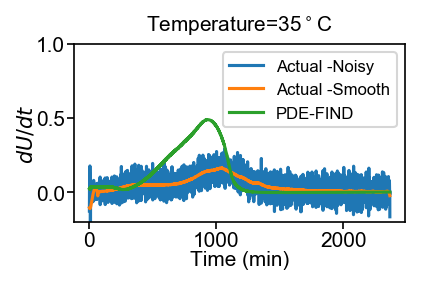

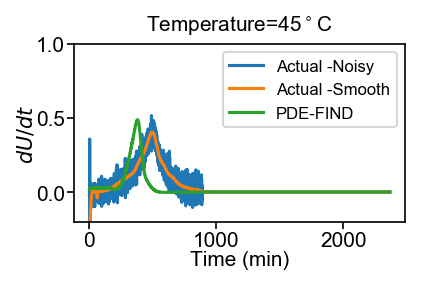

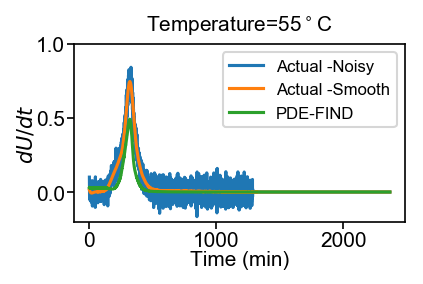

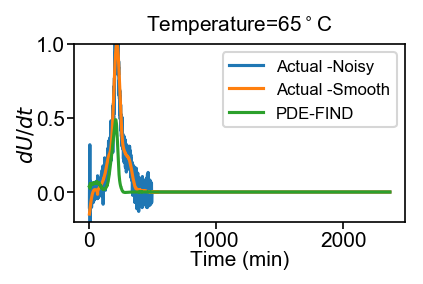

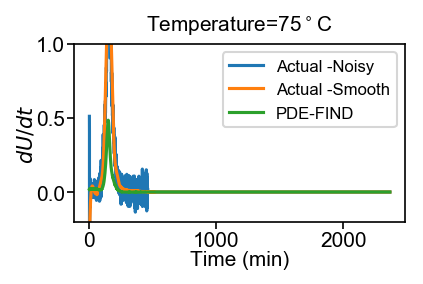

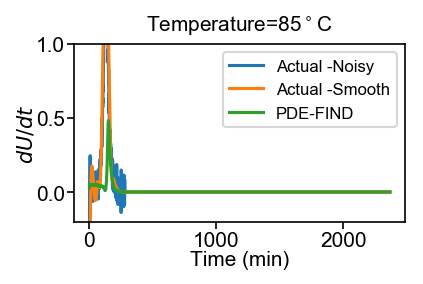

In [21]:
###--- comparing the actual derivative with PDE-FIND estimate ---###

mae_alld = [] # vector to store the MAE between actual derivative and PDE-FIND estimate

for i in range(len(T)):
    fig, ax = plt.subplots(1, 1, figsize = (3,2), dpi=150)
    ax.tick_params(axis='both', which='major', pad=1)
    plt.title("Temperature="+str(T[i]) + "$^\circ$C", fontsize = 10)
    
    # estimate actual derivative through PDE-FIND
    pde_data = np.tile(rml[i][:],(1,1))
    Ut_actual,_,_ = build_linear_system(pde_data, dt, dx, D=D0, P=P0, time_diff = method, space_diff = method)
    
    # First, the actual derivative needs to be smoothened. we use the savitzky-golay filter
    Ut_smooth = scipy.signal.savgol_filter(Ut_actual.reshape((-1)), 235, 5) 
    
    # PDE-FIND estimate
    Ut_pdefind = pdediffeq(redl[i,-1][:], time, T[i], w)
    
    
    plt.plot(time[:],Ut_actual[:], label = 'Actual -Noisy')
    plt.plot(time[:], Ut_smooth[:], label = 'Actual -Smooth')
    plt.plot(time[:], Ut_pdefind[:], label = 'PDE-FIND')
    
    plt.xlabel("Time (min)", fontsize = 10, labelpad = 0)
    plt.ylabel("$dU/dt$", fontsize = 10, labelpad = 0)
    plt.ylim(-0.2,1)
    plt.legend(fontsize = 8)
    
    # calculate MAE error
    mae_alld.append(mae(Ut_smooth,Ut_pdefind))
    
    plt.tight_layout()

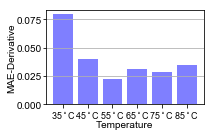

In [23]:
###--- bar-plot :comparing the actual derivative with PDE-FIND estimate ---###

fig, ax = plt.subplots(1, 1, figsize = (3,2))
ax.tick_params(axis='both', which='major', pad=1)
plt.bar(range(len(T)),np.divide(mae_alld,1),
        width = 0.8,
        color = 'b',
        align ='center',
        alpha=0.5,
        ecolor='black',
        capsize=14)

ax.set_ylabel('MAE-Derivative', fontsize = 10, labelpad = 0)
ax.set_xlabel('Temperature', fontsize = 10, labelpad = 0)

ax.set_xticks(range(len(T)))
ax.set_xticklabels([str(T[i])+'$^\circ$C' for i in range(len(T))], fontsize = 9)
ax.set_title('')
ax.yaxis.grid(True)
plt.tight_layout()

## Plot Integrals

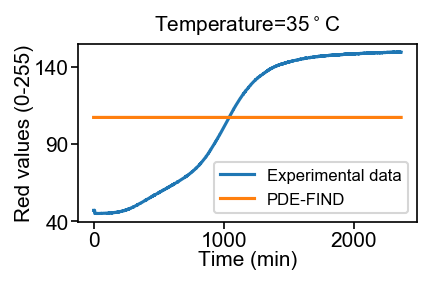

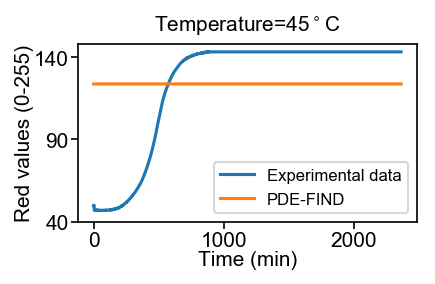

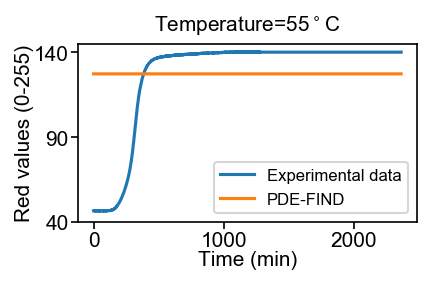

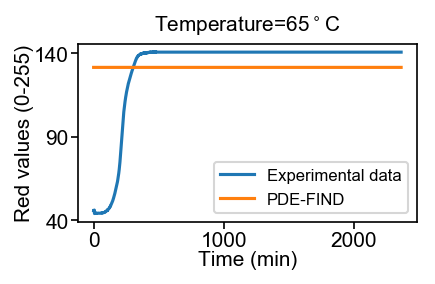

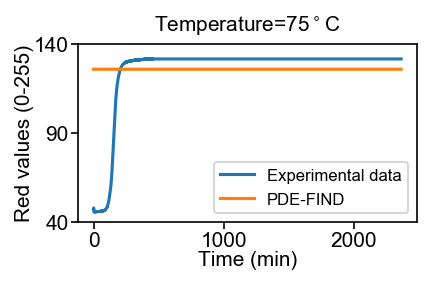

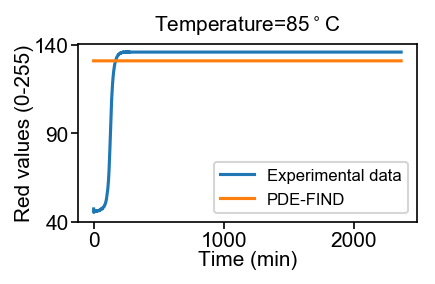

In [24]:
###--- comparing the actualexperimental data with curve obtained after integrating PDE-FIND's equation  ---###

mae_alli = []

for i in range(len(T)):
    fig, ax = plt.subplots(1, 1, figsize = (3,2), dpi=150)
    ax.tick_params(axis='both', which='major', pad=1)
    plt.title("Temperature="+str(T[i]) + "$^\circ$C", fontsize = 10)
    
    # estimate actual derivative through PDE-FIND
    pde_data = np.tile(rml[i][:],(1,1))
    Ut_actual,_,_ = build_linear_system(pde_data, dt, dx, D=D0, P=P0, time_diff = method, space_diff = method)
    
    # First, the actual derivative needs to be smoothened. we use the savitzky-golay filter
    Ut_smooth = scipy.signal.savgol_filter(Ut_actual.reshape((-1)), 235, 5) 
    
    # PDE-FIND estimate
    Ut_pdefind = pdediffeq(redl[i,-1][:], time, T[i], w)
    
    # integrate PDE-FINd equation with odeint
    U0 = bestUo(pdediffeq, w, time, T[i], i ) # inital conditions at t=0
    curve_pdefind = np.reshape(odeint(pdediffeq, U0, np.reshape(time[:],(-1)), args=(T[i],w)), (len(time[:])))
    
    plt.title("Temperature="+str(T[i])+ "$^\circ$C", fontsize = 10)
    plt.plot(time[:],rml[i][:], label = "Experimental data")
    plt.plot(time[:],curve_pdefind[:], label="PDE-FIND")
    plt.ylabel("Red values (0-255)", fontsize = 10, labelpad = 0)
    plt.xlabel("Time (min)", fontsize = 10, labelpad = 0)
    plt.legend(fontsize = 8)
    plt.yticks([40,90,140])
    
    plt.tight_layout()
    
    #calculate MAE error
    mae_alli.append(mae(rml[i],curve_pdefind))

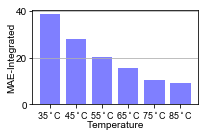

In [25]:
###--- bar-plot: comparing the actual data with PDE-FIND's estimate of integrated curve ---###

fig, ax = plt.subplots(1, 1, figsize = (3,2))
ax.tick_params(axis='both', which='major', pad=1)
plt.bar(range(len(T)),np.divide(mae_alli,1),
        width = 0.8,
        color = 'b',
        align ='center',
        alpha=0.5,
        ecolor='black',
        capsize=14)

ax.set_ylabel('MAE-Integrated', fontsize = 10, labelpad = 0)
ax.set_xlabel('Temperature', fontsize = 10, labelpad = 0)

ax.set_xticks(range(len(T)))
ax.set_xticklabels([str(T[i])+'$^\circ$C' for i in range(len(T))], fontsize = 9)
ax.set_title('')
ax.yaxis.grid(True)
plt.tight_layout()